<a href="https://www.kaggle.com/code/mariuszcha/titanic-from-scratch-fastai-pytorch?scriptVersionId=131636388" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### To enhance my knowledge, I decided to solve the Titanic dataset using various methods: traditional mathematical approaches, PyTorch and FastAI.

In [1]:
from fastai.tabular.all import *
import seaborn as sns
torch.manual_seed(13)

clean_data = pd.read_csv('/kaggle/input/titanic/train.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Math approach

I decided to define every function basically from scratch - not use already predefined in PyTorch

In [2]:
init_params = lambda size, std=0: (torch.rand(size)-std).requires_grad_()
mae = lambda pred, label: torch.abs(pred-label).mean()
relu = lambda x : torch.max(tensor(0),x)
sigmoid = lambda x: 1 / (1 + torch.exp(-x))
accuracyy = lambda pred, label: ((label.bool()==(pred>0.5)).float().mean())*100
scaler = lambda df: df / df.max()

def EDA(dff):
    df = dff.copy()
    modes = df.mode().iloc[0]
    df.fillna(modes, inplace=True)
    df['Fare'] = np.log1p(df['Fare'])
    df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
    df.drop(columns=['PassengerId','Name','Cabin','Ticket'], inplace=True)
    return df

def model(x):
    layer = x @ w1 + b1
    activated_layer = relu(layer)
    output = activated_layer @ w2 + b2
    return sigmoid(output)

def update_params(ps, lr):
    for p in ps:
        p.data -= p.grad.data * lr
        p.grad.zero_()

Here we are using already defined EDA function to clean our data. I decided to not focus on EDA and preprocessing but mostly on creating models by different methods.

In [3]:
data = EDA(clean_data)
props = int(data.shape[0] * 0.8)

y_train = tensor(data.iloc[:props,0].values, dtype = torch.float)
y_valid = tensor(data.iloc[props:,0].values, dtype = torch.float)

data = scaler(data)
X_train = tensor(data.iloc[:props,1:].values, dtype = torch.float)
X_valid = tensor(data.iloc[props:,1:].values, dtype = torch.float)

y_valid = y_valid.view(-1,1)
y_train = y_train.view(-1,1)

Epoch: 0 Loss: 0.3954758048057556 Accuracy 60.955055236816406
Epoch: 10 Loss: 0.3504054546356201 Accuracy 64.18539428710938
Epoch: 20 Loss: 0.30882778763771057 Accuracy 77.9494400024414
Epoch: 30 Loss: 0.2721866965293884 Accuracy 76.82584381103516
Epoch: 40 Loss: 0.24992075562477112 Accuracy 78.37078857421875
Epoch: 50 Loss: 0.2375054955482483 Accuracy 78.37078857421875
Epoch: 60 Loss: 0.23027195036411285 Accuracy 78.37078857421875
Epoch: 70 Loss: 0.2256162017583847 Accuracy 78.37078857421875
Epoch: 80 Loss: 0.2223011553287506 Accuracy 78.37078857421875
Epoch: 90 Loss: 0.21963730454444885 Accuracy 78.51123809814453
Epoch: 100 Loss: 0.217282235622406 Accuracy 78.7921371459961
Epoch: 110 Loss: 0.21683311462402344 Accuracy 78.7921371459961
Epoch: 120 Loss: 0.21638904511928558 Accuracy 78.7921371459961
Epoch: 130 Loss: 0.21594801545143127 Accuracy 79.07303619384766
Epoch: 140 Loss: 0.21551424264907837 Accuracy 79.21348571777344
Epoch: 150 Loss: 0.21508455276489258 Accuracy 79.3539352416992

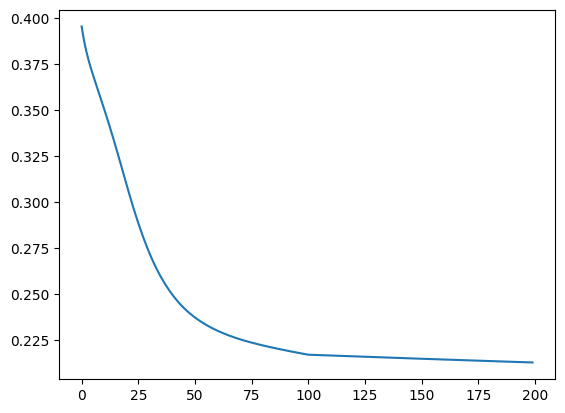

In [4]:
input_size = X_train.shape[1]
hidden_size = 16
output_size = 1
lr = 0.5
epochs = 200
losses = []

# Weights and biases
w1 = init_params((input_size,hidden_size),0.4)
b1 = torch.zeros(hidden_size).requires_grad_()
w2 = init_params((hidden_size,1),0.8)
b2 = torch.zeros(output_size).requires_grad_()
params = (w1, b1, w2, b2)

# Model learning for N epochs
for epoch in torch.arange(epochs):
    if epoch == 100: lr = 0.1 # <---
    pred = model(X_train)
    loss = mae(pred,y_train)
    losses.append(loss.item())
    loss.backward()
    if epoch%10==0: print('Epoch:',epoch.item(), 'Loss:', loss.item(),'Accuracy',accuracyy(pred,y_train).item())
    update_params(params, lr)
    
sns.lineplot(y=losses, x=torch.arange(epochs))
print('Train preds', accuracyy(model(X_train),y_train).item())
print('Test preds', accuracyy(model(X_valid),y_valid).item())

As we can see... for both - train set and validation set accuracy is about 80%. For very simple net defined from scratch, it's not terrible score. We also didn't focus on EDA and preprocessing data. By doing that, we definitely would improve our score.

# 2. FastAI approach

FastAI approach is the easiest one to do. As we can see - we also didn't focus on EDA here. More on creating proper model

In [5]:
acc = lambda preds, labels: ((preds[:,1] > 0.5) == labels).float().mean()
#learn.lr_find(suggest_funcs=(slide, valley))

def fastEDA(dff):
    df = dff.copy()
    df.drop(['PassengerId'], axis=1, inplace=True)
    df.Fare = np.log1p(df.Fare)
    return df

def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[16])
    with learn.no_logging(), learn.no_bar(): learn.fit(15, lr=0.3)
    return learn.get_preds(dl=test_data)[0]

In [6]:
fdata = fastEDA(clean_data)

# Creating 90-10 proportions; preparing train set and test set. From given train set, fastAI will make train and valid set.
props = int(fdata.shape[0]*0.9)
train_data = fdata.iloc[:props,:]
test_data = fdata.iloc[props:,:]

test_Y = tensor(test_data.pop('Survived'))

indices = RandomSplitter(seed=13)(train_data)

dls = TabularPandas(
    train_data,
    splits=indices,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked"],
    cont_names=['Age', 'SibSp', 'Parch', 'Fare'],
    y_names="Survived", 
    y_block = CategoryBlock(),
).dataloaders(path=".")

learn = tabular_learner(dls, metrics=accuracy, layers=[16])

# Transforming our test set using predefined transformers
test_data = learn.dls.test_dl(test_data)

learns = [ensemble() for _ in torch.arange(3)]
preds = torch.stack(learns).mean(0)
print(acc(preds, test_Y))

tensor(0.8333)


# 3. PyTorch approach

In [7]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

In [8]:
data = EDA(clean_data)
props = int(data.shape[0] * 0.8)

y_train = tensor(data.iloc[:props,0].values, dtype = torch.float)
y_valid = tensor(data.iloc[props:,0].values, dtype = torch.float)

data = scaler(data)
X_train = tensor(data.iloc[:props,1:].values, dtype = torch.float)
X_valid = tensor(data.iloc[props:,1:].values, dtype = torch.float)

y_valid = y_valid.view(-1,1)
y_train = y_train.view(-1,1)

Train accuracy: tensor(0.8090)
Test accuracy: tensor(0.8547)


<AxesSubplot: >

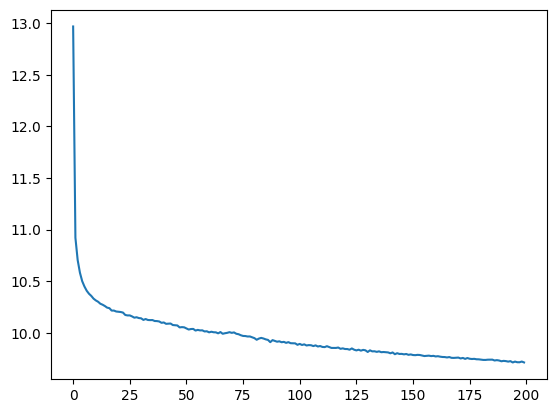

In [9]:
input_size = X_train.shape[1]
hidden_size = 16
output_size = 1
lr = 0.5
epochs = 200
batch_size = 32
losses = []

model = NN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = SGD(model.parameters(), lr=lr)

for epoch in torch.arange(epochs):
    running_lose = 0
    for i in range(0, len(X_train), batch_size):
        
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_lose += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(running_lose)

model.eval()
print('Train accuracy:',((model(X_train) > 0.5) == y_train).float().mean())
print('Test accuracy:',((model(X_valid) > 0.5) == y_valid).float().mean())

sns.lineplot(y=losses, x=torch.arange(epochs))

Our PyTorch approach perform better that From Scratch approach and FastAI, that could be connected with starting weights and biases or just the way how PyTorch activation functions or linear models are defined.